In [1]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import folium

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import geopandas as gp

import random


import time


import datetime

import scipy.stats as stats

## UDF

In [2]:
'''Get travel distance'''

def Get_distance(point1,point2):
    
    return Point(point1).distance(Point(point2))*111000*1.2

'''Get travel time'''

def Get_travel_time(dis,speed):
    
    return int(dis/speed)

'''Filter Zones'''

def Get_POLYGON(coords):
    if coords.type=='Polygon':
        return coords
    else:
        Score={i:coords[i].area for i in range(len(coords))}
        idx=max(Score, key=Score.get)
        return coords[idx]
    
'''Randomly Generate nodes'''

def Generate_Point(location,Zone_geometry):
    
    Poly=Zone_geometry[location]
    
    coordinates=list(Poly.exterior.coords)
    
    lngs=[x[0] for x in coordinates]
    
    lats=[x[1] for x in coordinates]
    
    lng_min,lng_max=min(lngs),max(lngs)
    
    lat_min,lat_max=min(lats),max(lats)
    
    lat=random.random()*(lat_max-lat_min)+lat_min
    
    lng=random.random()*(lng_max-lng_min)+lng_min
    
    pnt=Point(lng,lat)
    
    while Poly.contains(pnt)!=True:
        
        lat=random.random()*(lat_max-lat_min)+lat_min
    
        lng=random.random()*(lng_max-lng_min)+lng_min
    
        pnt=Point(lng,lat)
        
    return [lat,lng]

'''Week Transfer'''

def get_week_day(date):
    
    date=datetime.datetime.strptime(date, '%Y-%m-%d')
    
    week_day_dict = {
    0 : 'MON',
    1 : 'TUE',
    2 : 'WED',
    3 : 'THU',
    4 : 'FRI',
    5 : 'SAT',
    6 : 'SUN',
    }
    day = date.weekday()
    
    return week_day_dict[day]

def Get_minute(step):
    
    return int(step/6)

        

## Param

In [3]:
'''Param'''

resolution = 9

s_sec=25200

e_sec=36000

speed=20000/360

Driver_num=3000

'''Path'''

Demand_path='./Data/01Demand/'


'''Matching patience'''

Mean_match=5

Min_match=3

Max_match=7

Waiting_match=2


'''Load data'''

'''Grid-related data'''

Grid_list=np.load('./Data/NYC_Network/Grids.npy',allow_pickle=True)


'''Point-related data'''

Points_list=np.load('./Data/NYC_Network/Points_list.npy',allow_pickle=True)

Link_Point=np.load('./Data/NYC_Network/Link_Point.npy',allow_pickle=True).item()

Point_coordinate=np.load('./Data/NYC_Network/Point_coordinate.npy',allow_pickle=True).item()

Point_Grid=np.load('./Data/NYC_Network/Point_Grid.npy',allow_pickle=True).item()

''' Dividing NYC to Zones'''

Zone_data = gp.read_file('./Data/NYC_Zones/geo_export_789b911c-2a6d-4092-a682-6c5e6ce53409.shp')

Zone_data=Zone_data[['borough','zone','geometry','location_i']]

Zone_data=Zone_data.loc[Zone_data['borough']=='Manhattan']

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data=Zone_data[['Zone_id','borough','zone','geometry','location_i']]

Islands=['Zone_19','Zone_20','Zone_21','Zone_38','Zone_47','Zone_48']

# Islands=['Zone_19','Zone_20','Zone_21']

Zone_data=Zone_data.loc[~Zone_data['Zone_id'].isin(Islands)]

Zone_data=Zone_data.reset_index(drop=True)

Zone_data['Zone_id']=['Zone_'+str(i) for i in Zone_data.index]

Zone_data['geometry']=Zone_data.apply(lambda x:Get_POLYGON(x['geometry']),axis=1)

Zone_data['center'] = Zone_data.apply(lambda x:x['geometry'].centroid,axis=1)

Zone_data=Zone_data.rename(columns={'location_i':'LocationID'})

Zone_data[['LocationID']] = Zone_data[['LocationID']].astype(float)

Zone_data['type']=Zone_data.apply(lambda x:x['geometry'].type,axis=1)


Zone_geometry={}

for idx,row in Zone_data.iterrows():
    
    Zone_geometry[row['LocationID']]=row['geometry']
    


Locations=Zone_data['LocationID'].tolist()

<ipython-input-2-e50a34ba129c>:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  Score={i:coords[i].area for i in range(len(coords))}
<ipython-input-2-e50a34ba129c>:19: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  Score={i:coords[i].area for i in range(len(coords))}
<ipython-input-2-e50a34ba129c>:21: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return coords[idx]
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer

## Data Collection

In [4]:
GetStamp=lambda x:time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S'))

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

Order_df=pd.read_csv(os.path.join(Demand_path,'yellow_tripdata_2020-12.csv'))

Order_df=Order_df[['tpep_pickup_datetime','PULocationID','DOLocationID']]

Order_df=Order_df.loc[(Order_df['PULocationID'].isin(Locations))&(Order_df['DOLocationID'].isin(Locations))]

Order_df['date']=Order_df.apply(lambda x:x['tpep_pickup_datetime'][0:10],axis=1)

Order_df['Arrive_stamp']=Order_df.apply(lambda x:GetStamp(x['tpep_pickup_datetime']),axis=1)

Order_df['Order_id'] = ['O'+str(i) for i in Order_df.index]

Order_df['Driver_id'] = 'Waiting'

Start_step=2520 # Start stamp 

End_step=3600 # End stamp 

Order_Num={}

for dt in Dates:
    
    order_df=copy.deepcopy(Order_df.loc[Order_df['date']==dt])
    
    base_line=GetStamp(dt+' 00:00:00')
    
    order_df['Arrive_second']=order_df.apply(lambda x:int(x['Arrive_stamp']-base_line),axis=1)
    
    order_df['Arrive_step']=order_df.apply(lambda x:int(x['Arrive_second']/10),axis=1)
    
    order_df=order_df.loc[(order_df['Arrive_step']>=Start_step)&(order_df['Arrive_step']<End_step)]
    
    order_df['Response_step']=3600*24
    
    order_df['Pickup_step']=3600*24
    
    order_df['Pickup_Point']=order_df.apply(lambda x:Generate_Point(x['PULocationID'],Zone_geometry),axis=1)

    order_df['Dropoff_Point']=order_df.apply(lambda x:Generate_Point(x['DOLocationID'],Zone_geometry),axis=1)

    order_df['Pickup_Latitude']=order_df.apply(lambda x:x['Pickup_Point'][0],axis=1)

    order_df['Pickup_Longitude']=order_df.apply(lambda x:x['Pickup_Point'][1],axis=1)

    order_df['Dropoff_Latitude']=order_df.apply(lambda x:x['Dropoff_Point'][0],axis=1)

    order_df['Dropoff_Longitude']=order_df.apply(lambda x:x['Dropoff_Point'][1],axis=1)

    order_df['Pickup_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Pickup_Latitude'],x['Pickup_Longitude'],resolution),axis=1)

    order_df['Dropoff_Grid']=order_df.apply(lambda x:h3.geo_to_h3(x['Dropoff_Latitude'],x['Dropoff_Longitude'],resolution),axis=1)
    
    order_df=order_df.loc[order_df['Pickup_Grid'].isin(Grid_list)]
    
    order_df=order_df.loc[order_df['Dropoff_Grid'].isin(Grid_list)]
     
    order_df['Travel_dis']=order_df.apply(lambda x:Get_distance(x['Pickup_Point'],x['Dropoff_Point']),axis=1)
    
    order_df['Travel_time']=order_df.apply(lambda x:int(Get_travel_time(x['Travel_dis'],speed)),axis=1)
    
    order_df=order_df[['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
   'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
   'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
   'Dropoff_Point', 'Travel_dis', 'Travel_time','date']]
    
    order_df.to_csv(os.path.join(Demand_path,'Order_df_'+str(dt)+'.csv'))
    
    print(f'The number of orders in '+str(dt)+' is '+str(order_df.shape[0]))
    

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
'''Stochastic Matching '''

def Truncated_Gauss(mu,sigma,lower,upper,num):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return [round(x,0) for x in X.rvs(num)]

'''Surging Pricing'''

def Price(distance,duration,base_fare=2.55,minimum_fare=7):
    
    fare=base_fare+distance*1.75+0.35*duration
    
    fare=max(fare,minimum_fare)
    
    return fare
    
    
Order_DF=pd.DataFrame([],columns=['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
       'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
       'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
       'Dropoff_Point', 'Travel_dis', 'Travel_time', 'date', 'Matching_patience','Fare'],dtype=object)


'''Pick up 10 week days'''

Weekdays=[]

Dates=[str(x)[:10] for x in pd.date_range('12/1/2020','12/31/2020')]

for dt in Dates:
    
    if get_week_day(dt) not in ['SAT','SUN']:
        
        Weekdays.append(dt)
        
    if len(Weekdays)>10:
        
        break
        
        


for day in Weekdays:

    Order_df=pd.read_csv(os.path.join(Demand_path,'Order_df_'+str(day)+'.csv'))

    Order_df=Order_df.drop(columns=['Unnamed: 0'])
    
    Order_num=Order_df.shape[0]
    
    Matching_patience=Truncated_Gauss(Mean_match,Waiting_match,Min_match,Max_match,Order_num)
    
    Order_df['Matching_patience']=Matching_patience
    
    Order_df['Travel_duration']=Order_df.apply(lambda x:int(x['Travel_time']/6),axis=1)
    
    Order_df['Travel_distance']=Order_df.apply(lambda x:(x['Travel_dis']/1000.0)*0.62,axis=1)
    
    Order_df['Fare']=Order_df.apply(lambda x:Price(x['Travel_distance'],x['Travel_duration']),axis=1)
    
    Order_df=Order_df.sort_values(by=['Arrive_step'])
    
    Order_df=Order_df.loc[(Order_df['Arrive_step']>=Start_step)&(Order_df['Arrive_step']<End_step)]

    Order_df=Order_df[['Order_id', 'Driver_id', 'Arrive_step', 'Response_step', 'Pickup_step',
       'Pickup_Latitude', 'Pickup_Longitude', 'Dropoff_Latitude',
       'Dropoff_Longitude', 'Pickup_Grid', 'Dropoff_Grid', 'Pickup_Point',
       'Dropoff_Point', 'Travel_dis', 'Travel_time', 'date', 'Matching_patience','Fare']]
    
    Order_df.to_csv(os.path.join(Demand_path,'Order_df_'+str(day)+'.csv'))
    
    Order_DF=pd.concat([Order_DF,Order_df],ignore_index=True)
    
    print(f'The number of orders in '+str(day)+' is '+str(Order_df.shape[0]))
    

    
Order_df

## Data Visualization

In [66]:
Southwest=[40.684289, -74.025695]

Northeast=[40.882081, -73.889064]

Map_path='./Data/Map/'

font_title = {'family' : 'Arial','weight' : 'normal','size': 25}

font_label = {'family' : 'Arial','weight' : 'normal','size': 20}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

def Background(area,sw,ne):
    
    bg_path=Map_path+area+'.png'
    
    img = plt.imread(bg_path)
    
    figsize = 15,30
    
    figure, ax1 = plt.subplots(figsize=figsize)
    
    xgrange, ygrange = ((sw[1], ne[1]), (sw[0], ne[0]))
    


    labels = ax1.get_xticklabels() + ax1.get_yticklabels()

    [label.set_fontsize(15) for label in labels]

    [label.set_fontname('Arial') for label in labels]

    ax1.set_xlim(xgrange)

    ax1.set_ylim(ygrange)

    x0,x1 = ax1.get_xlim()

    y0,y1 = ax1.get_ylim()

    ax1.imshow(img, extent=[x0, x1, y0, y1], aspect='auto', alpha=.5)

    ax1.set_xlabel('Longitude',font_label)

    xmajorLocator   = MultipleLocator(0.04)

    ax1.xaxis.set_major_locator(xmajorLocator)

    ax1.set_ylabel('Latitude',font_label)

    ymajorLocator1   = MultipleLocator(0.05)

    ax1.yaxis.set_major_locator(ymajorLocator1)
    
    return figure, ax1





In [67]:
Origin_STAT=Order_DF.groupby(['Pickup_Grid']).count()

Origin_STAT['Grid']=Origin_STAT.index

Origin_STAT=Origin_STAT.reset_index(drop=True)

Origin_STAT=Origin_STAT.rename(columns={'Order_id':'Order_Num'})

Origin_STAT=Origin_STAT[['Grid','Order_Num']]

Origin_STAT['Order_Num']=Origin_STAT.apply(lambda x:x['Order_Num']/len(Weekdays),axis=1)

Origin_STAT['ratio']=Origin_STAT.apply(lambda x:(x['Order_Num']-min(Origin_STAT['Order_Num']))/(max(Origin_STAT['Order_Num'])-min(Origin_STAT['Order_Num'])),axis=1)

Origin_STAT=Origin_STAT.round({'ratio':2})

Origin_STAT.to_csv('./Data/01Spatial_Value/Origin_STAT.csv')

Origin_STAT


,Grid,Order_Num,ratio
0,892a1008803ffff,25.272727,0.22
1,892a1008807ffff,31.272727,0.27
2,892a100880bffff,0.727273,0.01
3,892a100880fffff,28.636364,0.25
4,892a1008813ffff,19.454545,0.17
...,...,...,...
570,892a1072dcfffff,0.090909,0.00
571,892a1072dd3ffff,0.363636,0.00
572,892a1072dd7ffff,0.090909,0.00
573,892a1072ddbffff,2.000000,0.02


<ipython-input-74-e016531fe49c>:26: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.annotate(s=str(ratio),fontsize=8,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))


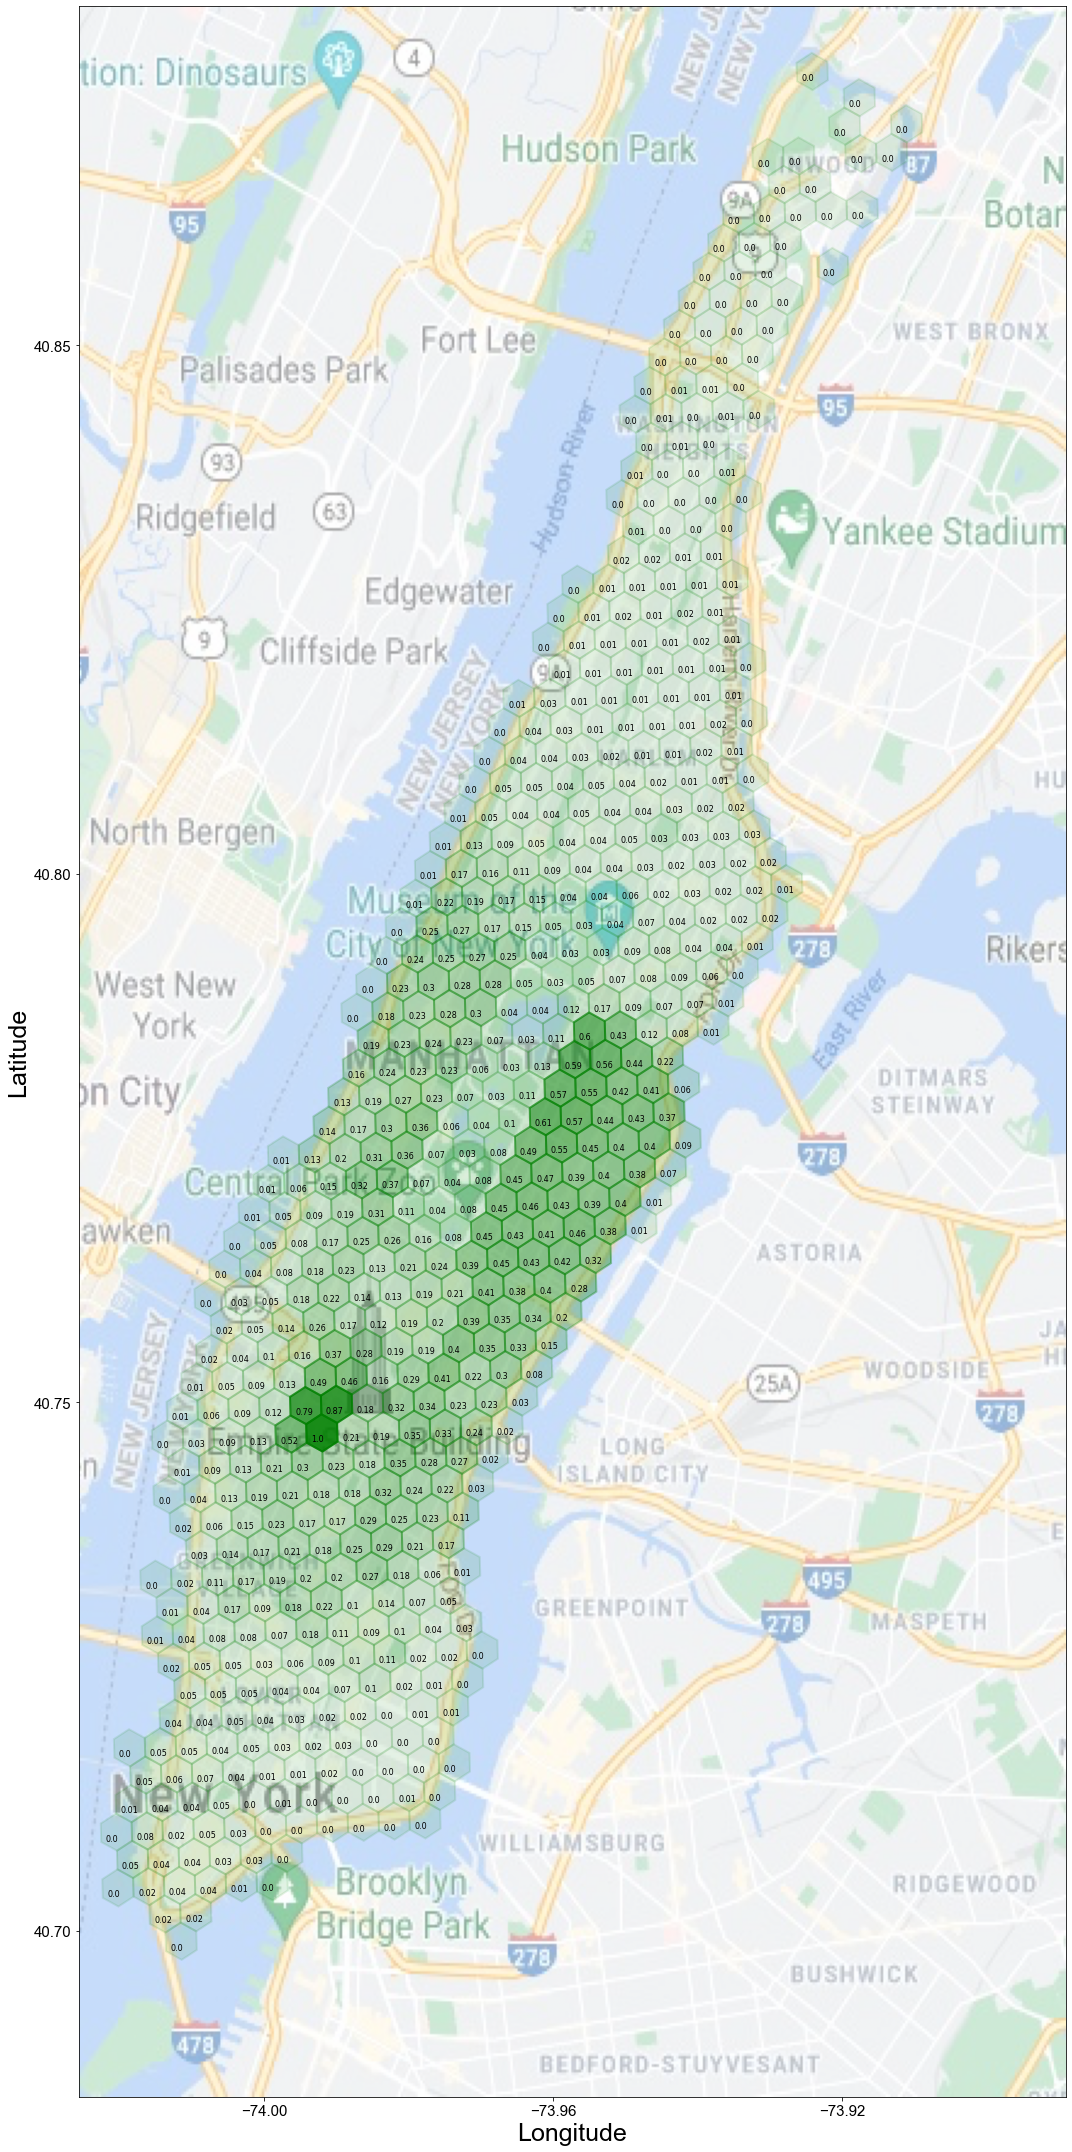

In [74]:

'''Heatmap'''

figure, ax1=Background('NYC',Southwest,Northeast)


    
    
'''Heatmap'''

for idx,row in Origin_STAT.iterrows():
    
    grid=row['Grid']
    
    ratio=row['ratio']
    
    num=int(row['Order_Num'])
    
    boundary=[[float(x[1]),float(x[0])] for x in h3.h3_to_geo_boundary(grid)]

    pgon = plt.Polygon(boundary,color='green',linewidth=2,fill=True,alpha=0.8*ratio+0.1)

    ax1.add_patch(pgon)
    
    coordinates=h3.h3_to_geo(grid)

    ax1.annotate(s=str(ratio),fontsize=8,xy=(1.00002*coordinates[1],0.99998*coordinates[0]))
    

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('./Data/02Spatial_Value/Spatial_Value.png', format='png',bbox_inches = 'tight')

plt.show()

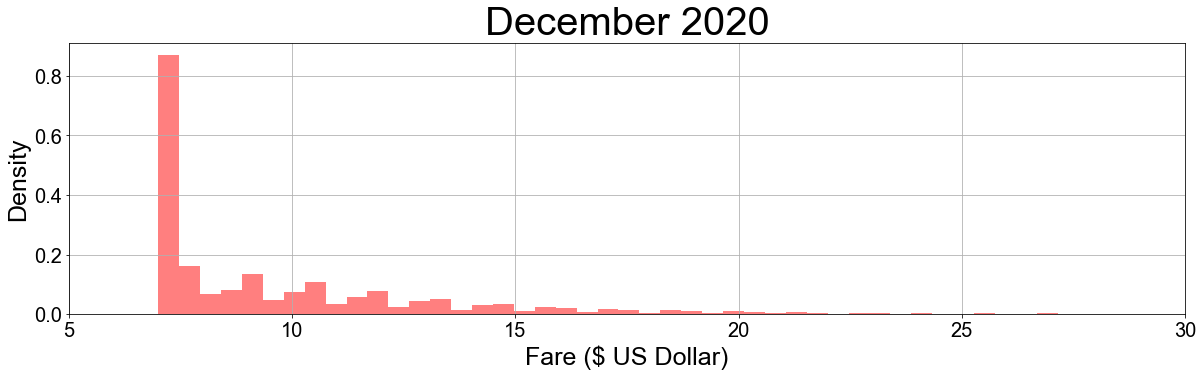

In [75]:
Array=copy.deepcopy(np.array(Order_DF['Fare'].to_list()))

Array.sort()




'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(figsize=figsize)


labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Arial') for label in labels]

'''Plot'''

Y, X, l1 =ax1.hist(Array,\
          bins=100,\
          facecolor='r',\
          label='Real-world observation',\
          density=True,\
          alpha=0.5)


ax1.grid()

ax1.set_ylabel('Density',font_label)

ax1.set_xlabel('Fare ($ US Dollar)',font_label)

ax1.set_xlim([5,30])

ax1.set_title('December 2020',font_title)

current_fig = plt.gcf() # 'get current figure'


plt.show()